In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XAI_Nuc.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'XAI_Nuc' already exists and is not an empty directory.


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
import os
sys.path.append("/content/XAI_Nuc/")

In [4]:
import shap

In [5]:
%cd /content/XAI_Nuc

/content/XAI_Nuc


In [6]:
import criticNet.model
import actorNet.model

In [7]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [8]:
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box

class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1
        
        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        self.State = np.zeros((5, 1))
        self.IsDone = False
        
    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]
        


        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]
        
        Month += 1
        PartReplaced1 = 0
        
        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1
            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth
        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap
        
        if Month % self.RefuelPeriod != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)
        
        Component1 = max(Component1, 0)  # Health can not be less than 0
        
        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,0.01)
            # Sensor1 = max(min(Sensor1, 1), 0.01)
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod
        
        # data = np.array(ArrivalDate1)
        # updated_data = np.array([data[0][0] - 1])
                  # ArrivalDate1 -= 1

        ArrivalDate1 = [x - 1 for x in ArrivalDate1];
        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog
        
        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)
        
        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0
        
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))
        
        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)
        # self.State = tf.convert_to_tensor(State, dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        # observation = tf.reshape(Observation, (1, -1))    

        
        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}
    
    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod
        
        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)
        # self.State = tf.convert_to_tensor(State, dtype=tf.float32)
        return initial_observation
    
    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]
        
        Action1 = Action[0]
        OrderPart1 = Action[1]
        
        reward = 0
        
        if Inv1 > 0:
            reward += self.CostInventory * Inv1
        
        reward += self.CostToOrder * OrderPart1
        
        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        
        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace
        
        return reward


In [9]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 2000

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

actor = model_actorNet
critic = model_criticNet
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        # state_tensor = tf.expand_dims(state_tensor, 0)
        state_tensor = tf.reshape(state, (1, -1))    

        state_tensors.append(state_tensor)  # Save state_tensor to the list

        # Get action probabilities from actor network
        action_probs = actor(state_tensor)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        action_index = action_log_prob.numpy().item()

        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action
        action = actionelements[action_index]
    
        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)
   
        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break
        

    # print("Episode {}: Reward = {}".format(episode, episode_reward))
    state_log = tf.squeeze(state_tensors)
    action_log = tf.squeeze(actionss)
    rewards = tf.squeeze(episode_rewards)
    state_log = np.array(state_log)
    action_log = np.array(action_log)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


[1 0]
[0.88888889 0.9865412  0.         0.         0.        ]
[1 0]
[0.83333333 0.98764241 0.         0.         0.        ]
[1 0]
[0.77777778 0.98842741 0.         0.         0.        ]
[1 0]
[0.72222222 0.98750133 0.         0.         0.        ]
[1 0]
[0.66666667 0.98763284 0.         0.         0.        ]
[1 0]
[0.61111111 0.98830559 0.         0.         0.        ]
[1 0]
[0.55555556 0.98919788 0.         0.         0.        ]
[1 0]
[0.5        0.99012781 0.         0.         0.        ]
[1 0]
[0.44444444 0.98866566 0.         0.         0.        ]
[1 0]
[0.38888889 0.98896992 0.         0.         0.        ]
[1 0]
[0.33333333 0.98855528 0.         0.         0.        ]
[1 0]
[0.27777778 0.98874855 0.         0.         0.        ]
[1 0]
[0.22222222 0.98961394 0.         0.         0.        ]
[1 0]
[0.16666667 0.98988682 0.         0.         0.        ]
[1 0]
[0.11111111 0.9894022  0.         0.         0.        ]
[1 0]
[0.05555556 0.99026283 0.         0.         0.  

In [10]:
'Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1'

('Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1')

(<Axes: ylabel='Action'>,
 Text(0, 0.5, 'Action'))

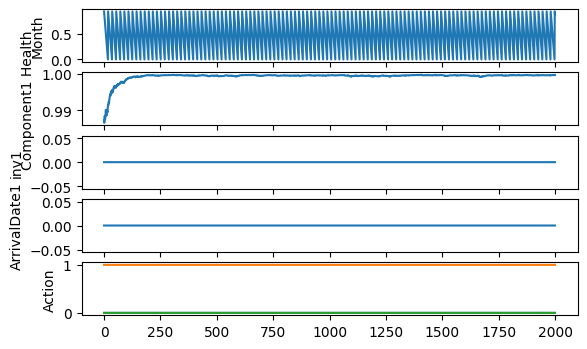

In [11]:
plt.figure()
plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Month')
plt.subplot(612), plt.plot(state_log[:,1]), plt.ylabel('Component1 Health')
plt.subplot(613), plt.plot(state_log[:,2]), plt.ylabel('inv1')
plt.subplot(614), plt.plot(state_log[:,3]), plt.ylabel('ArrivalDate1')
plt.subplot(615), plt.plot(state_log[:,4]), plt.ylabel('fPartReplaced1')
plt.subplot(615), plt.plot(action_log[:]), plt.ylabel('Action')


In [12]:
# Define the names of the states
feature_names=['Month', 'Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1']

In [13]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log=state_log, feature_names=feature_names, action_log=action_log, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = ([observation], action) # define inputs and outputs of actor
    explainer = shap.KernelExplainer(model_actorNet, state_log)
    shap_values = explainer.shap_values(state_log) # Calculate shap values
       
    state_log_re = state_log # rescale state log 
    
    norm = plt.Normalize(vmin=0, vmax=2) # define color scala between -1 and +1 (like the agents action space)  
        
    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    # axs[0].scatter((action_log.size), action_log[0], c=action_log - explainer.expected_value[0], cmap=cmap, norm=norm)
    # axs[0].scatter(range(len(action_log)), action_log, c=action_log - explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action')
    axs[1].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])   
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])   
    axs[5].yaxis.set_label_position('right')   


    
    if save_fig:
        fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')

    

  0%|          | 0/2000 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


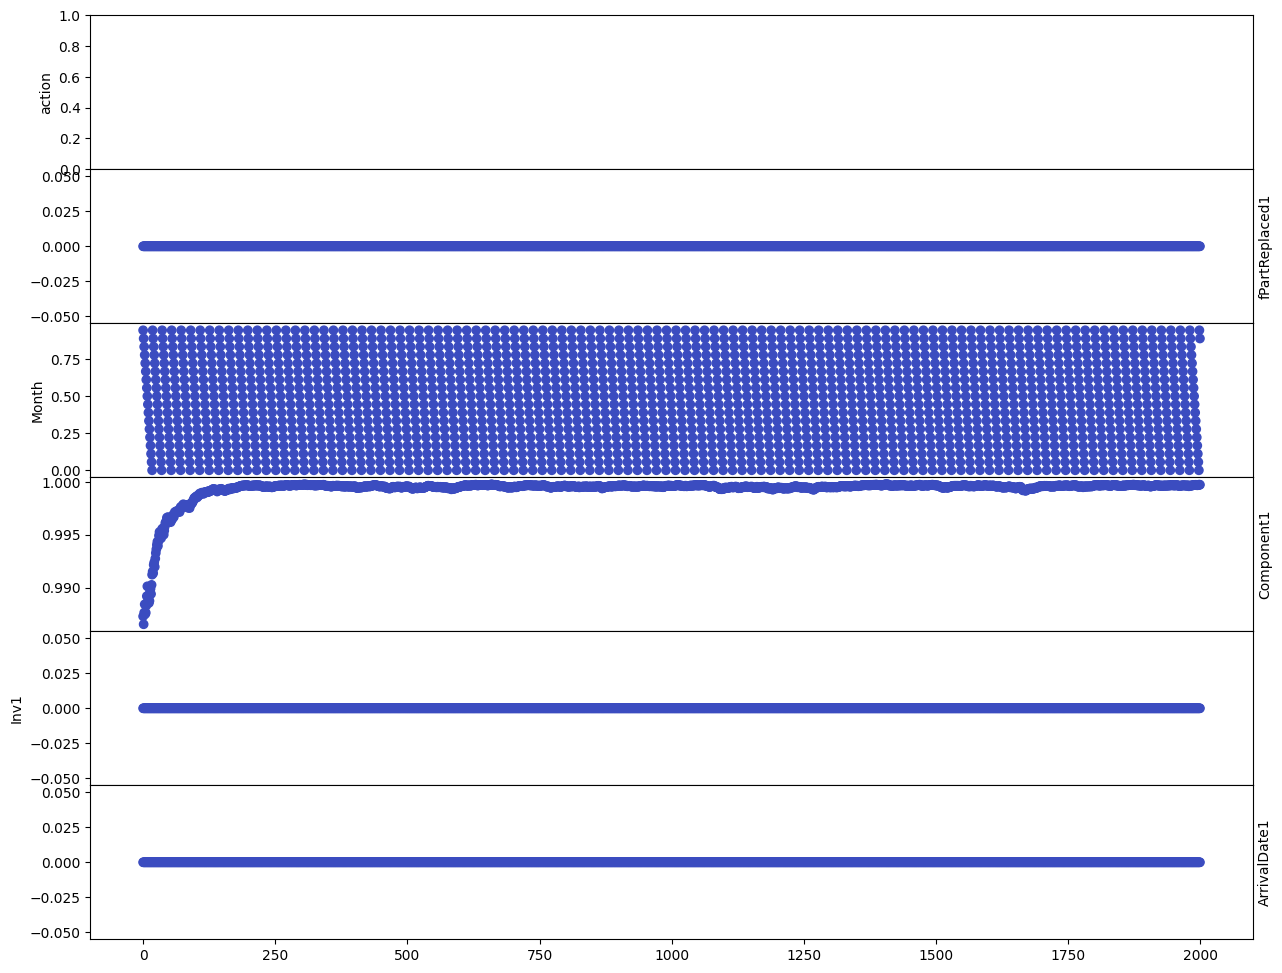

In [14]:
import matplotlib.pyplot as plt

# output with shap values
explain(model_actorNet, model_criticNet, state_log, feature_names, action_log)

In [15]:
explainer = shap.KernelExplainer(model_actorNet, state_log)
shap_values = explainer.shap_values(state_log) # Calculate shap values

  0%|          | 0/2000 [00:00<?, ?it/s]

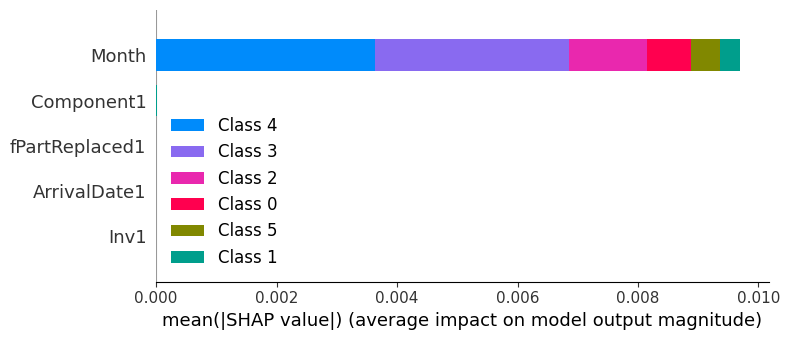

In [16]:
shap.summary_plot(shap_values, feature_names=feature_names)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


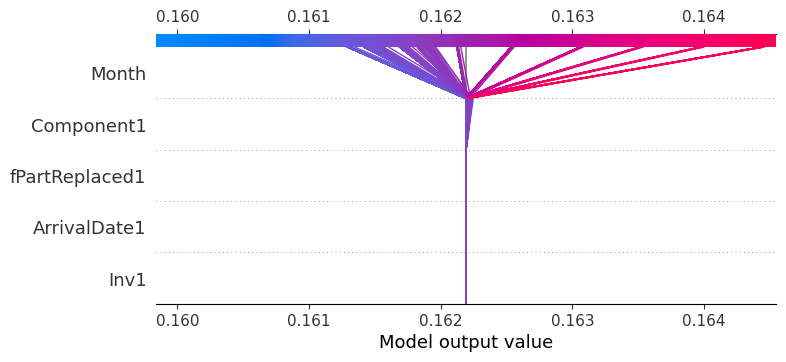

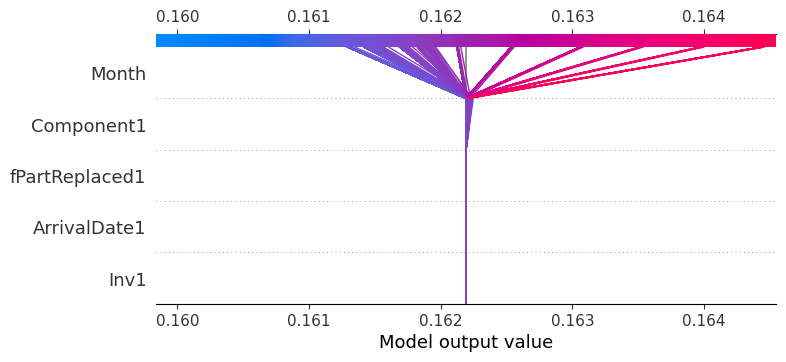

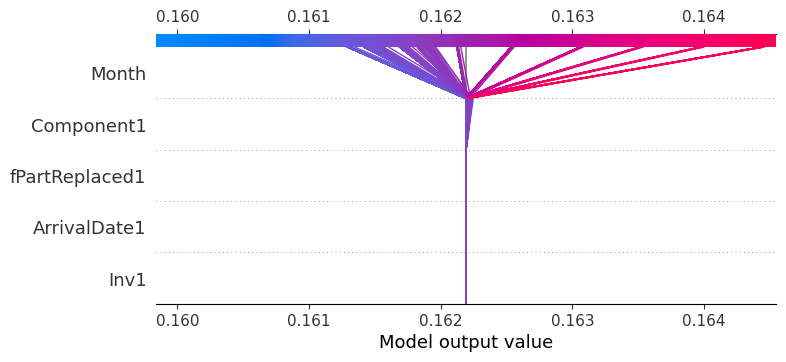

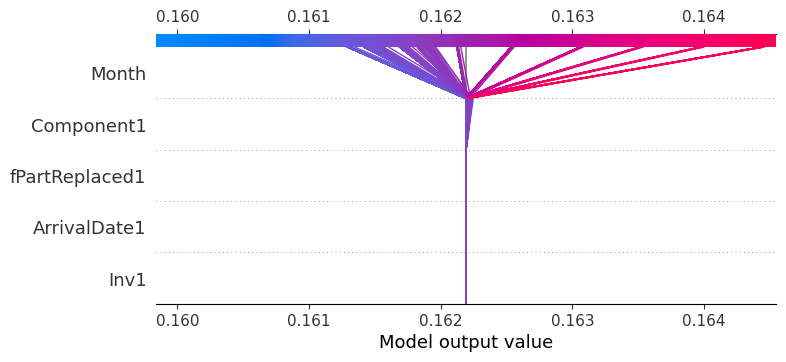

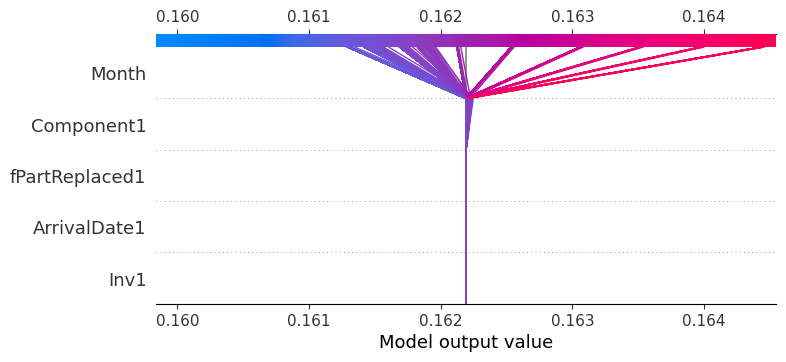

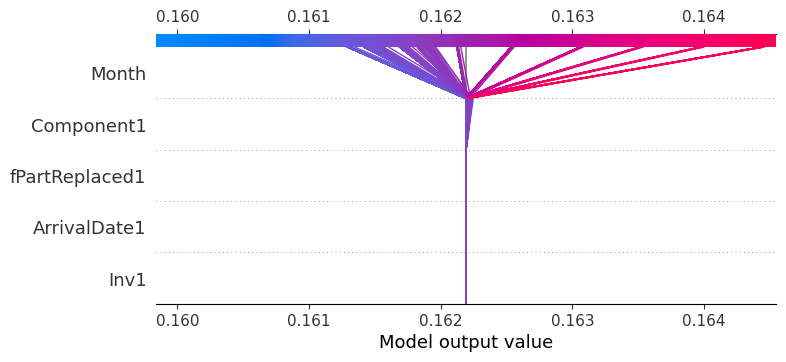

In [17]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


In [18]:
explainer = shap.KernelExplainer(model_criticNet, state_log)
shap_values = explainer.shap_values(state_log) # Calculate shap values

  0%|          | 0/2000 [00:00<?, ?it/s]

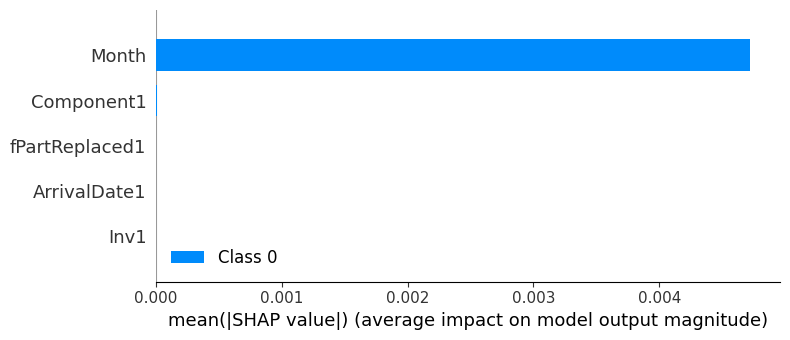

In [19]:
shap.summary_plot(shap_values, feature_names=feature_names)

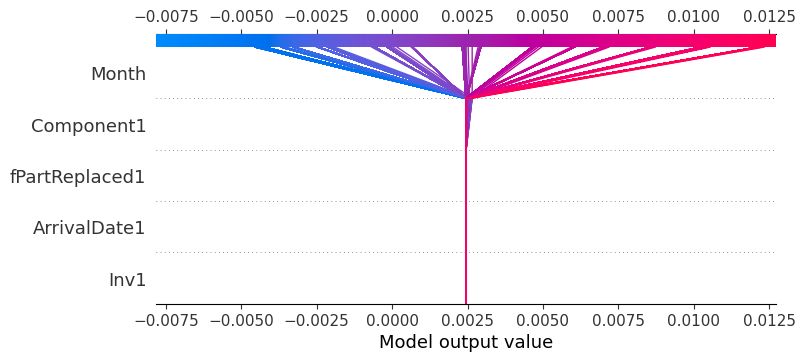

In [20]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


